In [ ]:
import os
import pandas as pd
pd.set_option('display.max_columns', None)
os.environ['MPLBACKEND'] = 'Agg'
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

# Training Data Setup

The training and validation data provided for the Virtual Cell Challenge is from H1 cells. STATE is meant for context generalization, not perturbation generalization, so we need a separate dataset to jointly train on to learn perturbation embeddings. In our case, we jointly train on the [Replogle genome wide and essential screens](https://plus.figshare.com/articles/dataset/_Mapping_information-rich_genotype-phenotype_landscapes_with_genome-scale_Perturb-seq_Replogle_et_al_2022_processed_Perturb-seq_datasets/20029387). We have already filtered the data to only include the 200 perturbations that appear in the competition train / val set.

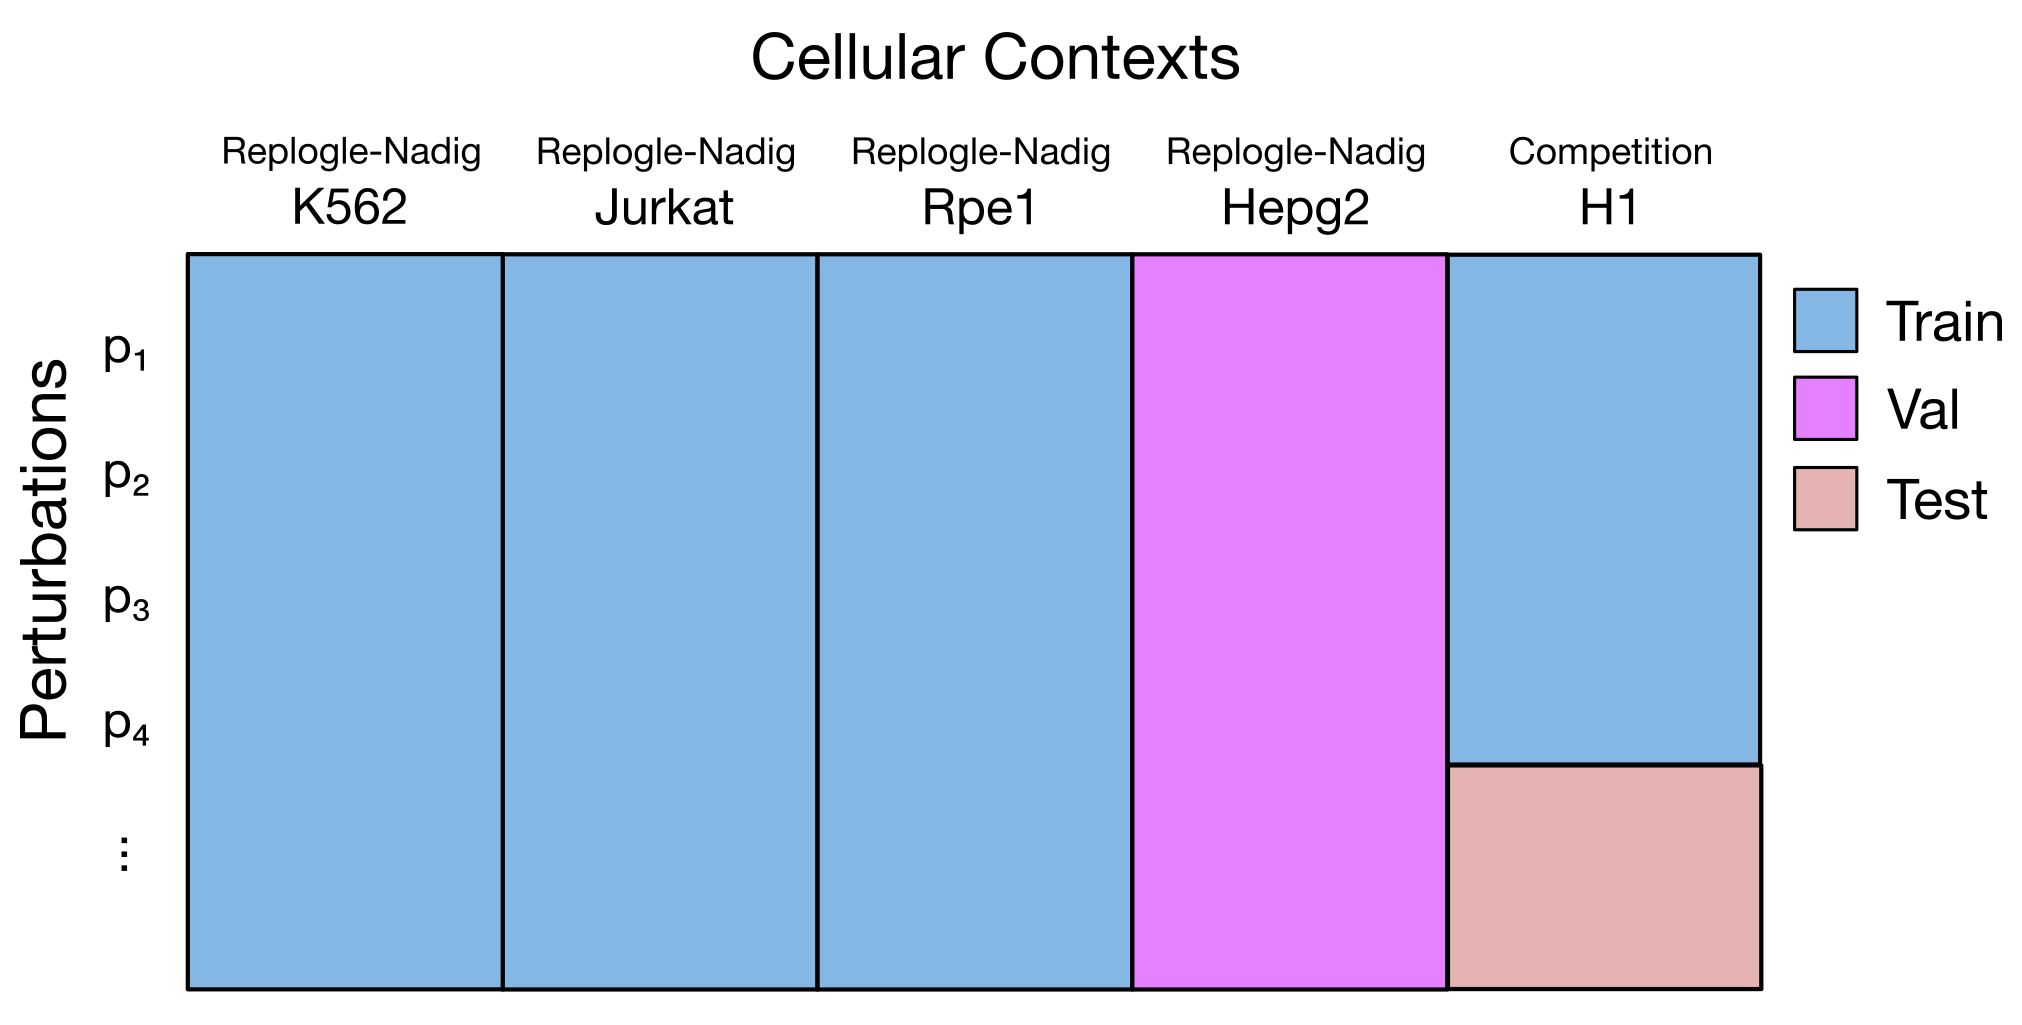

In [ ]:
import requests
from tqdm.auto import tqdm  # picks the best bar for the environment

url = "https://storage.googleapis.com/vcc_data_prod/datasets/state/competition_support_set.zip"
output_path = "competition_support_set.zip"

# stream the download so we can track progress
response = requests.get(url, stream=True)
total = int(response.headers.get("content-length", 0))

with open(output_path, "wb") as f, tqdm(
    total=total, unit='B', unit_scale=True, desc="Downloading"
) as bar:
    for chunk in response.iter_content(chunk_size=8192):
        if not chunk:
            break
        f.write(chunk)
        bar.update(len(chunk))

In [ ]:
from zipfile import ZipFile
from tqdm.auto import tqdm
import os

out_dir  = "competition_support_set"

os.makedirs(out_dir, exist_ok=True)

with ZipFile(output_path, 'r') as z:
    for member in tqdm(z.infolist(), desc="Unzipping", unit="file"):
        z.extract(member, out_dir)

In [ ]:
# @title Set Weights and Biases Entity for tracking
entity = "arcinstitute" # @param {"type":"string","placeholder":"arcinstitute"}
! sed -i 's|entity: your_entity_name|entity: {entity}|g' src/state/configs/wandb/default.yaml

In [ ]:
# Baseline STATE Model Training
! uv run state tx train \
  data.kwargs.toml_config_path="./competition_support_set/starter.toml" \
  data.kwargs.num_workers=8 \
  data.kwargs.batch_col="batch_var" \
  data.kwargs.pert_col="target_gene" \
  data.kwargs.cell_type_key="cell_type" \
  data.kwargs.control_pert="non-targeting" \
  data.kwargs.perturbation_features_file="./competition_support_set/ESM2_pert_features.pt" \
  training.max_steps=40000 \
  training.ckpt_every_n_steps=10 \
  training.use_graph_reg_loss=false \
  model=state_sm \
  wandb.tags="[first_run]" \
  wandb.project=vcc \
  wandb.entity=arcinstitute \
  output_dir="competition" \
  name="STATE_Baseline"

In [ ]:
# Baseline STATE Model Inference
! uv run state tx infer \
  --output "competition/STATE_Baseline/hepg2_prediction.h5ad" \
  --model-dir "competition/STATE_Baseline" \
  --checkpoint "competition/STATE_Baseline/checkpoints/step=20000.ckpt" \
  --adata "competition_support_set/hepg2.h5" \
  --pert-col "target_gene"

In [ ]:
# Baseline STATE Model Evaluation
! uvx -q --from git+https://github.com/ArcInstitute/cell-eval@v0.5.42 cell-eval run \
    -ap competition/STATE_Baseline/hepg2_prediction.h5ad \
    -ar competition_support_set/hepg2.h5 \
    -o . \
    --skip-metrics clustering_agreement,pearson_edistance \
    --batch-size 1024 \
    --num-threads 64 \
    --outdir "cell-eval-out-Baseline" \

In [ ]:
# Baseline STATE Model Results
results = pd.read_csv('./cell-eval-out-Baseline/agg_results.csv')
results[results.statistic == 'mean']

In [ ]:
# STATE Plus Model Training
! uv run state tx train \
  data.kwargs.toml_config_path="./competition_support_set/starter.toml" \
  data.kwargs.num_workers=8 \
  data.kwargs.batch_col="batch_var" \
  data.kwargs.pert_col="target_gene" \
  data.kwargs.cell_type_key="cell_type" \
  data.kwargs.control_pert="non-targeting" \
  data.kwargs.perturbation_features_file="./competition_support_set/ESM2_pert_features.pt" \
  training.max_steps=40000 \
  training.ckpt_every_n_steps=10 \
  training.use_graph_reg_loss=true \
  model=state_sm \
  wandb.tags="[first_run]" \
  wandb.project=vcc \
  wandb.entity=arcinstitute \
  output_dir="competition" \
  name="STATE_Plus"

In [ ]:
# STATE Plus Model Inference
! uv run state tx infer \
  --output "competition/STATE_Plus/hepg2_prediction.h5ad" \
  --model-dir "competition/STATE_Plus" \
  --checkpoint "competition/STATE_Plus/checkpoints/step=20000.ckpt" \
  --adata "competition_support_set/hepg2.h5" \
  --pert-col "target_gene"

In [ ]:
# STATE Plus Model Evaluation
! uvx -q --from git+https://github.com/ArcInstitute/cell-eval@v0.5.42 cell-eval run \
    -ap competition/STATE_Plus/hepg2_prediction.h5ad \
    -ar competition_support_set/hepg2.h5 \
    -o . \
    --skip-metrics clustering_agreement,pearson_edistance \
    --batch-size 1024 \
    --num-threads 64 \
    --outdir "cell-eval-out-STATE_Plus" \

In [ ]:
# STATE Plus Model Results
results = pd.read_csv('./cell-eval-out-STATE_Plus/agg_results.csv')
results[results.statistic == 'mean']